In [ ]:
!pip install -U quandl numpy pandas requests pandas-datareader DateTime yahoo_fin seaborn scipy numpy-financial

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy_financial as npf
from statistics import NormalDist
from scipy.optimize import minimize
from scipy import stats
from pandas_datareader import data, wb
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta

# Utils

In [2]:
def calculate_return(annual_return, weights):
    return sum(annual_return * weights.T)

def calculate_volatility(cov_metrix, weights):
    portfolio_variance = np.dot(weights.T, np.dot(cov_metrix, weights))
    #standard deviation (risk of portfolio)
    portfolio_risk = np.sqrt(portfolio_variance)
    return portfolio_risk

def calculate_sharpe_ratio(p_return, p_risk):
    return p_return / p_risk

def neg_sharpe(weights, cov_matrix, annual_returns):
    p_risk = calculate_volatility(cov_matrix, weights)
    p_return = calculate_return(annual_returns, weights)
    return calculate_sharpe_ratio(p_return, p_risk) * -1

def simulate_portfolio_returns(years, annual_payment, initial_investment, p_return, p_risk):
    portfolio_distribution = NormalDist(mu=p_return, sigma=p_risk)
    r_0 = portfolio_distribution.inv_cdf(random.random())
    d = {
        "investment": [initial_investment],
        "return": [portfolio_distribution.inv_cdf(random.random())],
        "balance": [initial_investment + initial_investment * r_0],
    }
    for year in range(years):
        investement = d["balance"][len(d["balance"]) - 1] + annual_payment
        return_this_year = portfolio_distribution.inv_cdf(random.random())
        balance = investement + investement * return_this_year
        d["investment"].append(d["investment"][len(d["investment"]) - 1] + annual_payment)
        d["return"].append(return_this_year)
        d["balance"].append(balance)
    return pd.DataFrame.from_dict(d)

def simulate_ending_balances(n, years, annual_payment, initial_investment, p_return, p_risk):
    result = []
    for i in range(n):
        returns = simulate_portfolio_returns(years, annual_payment, initial_investment, p_return, p_risk)
        ending_balance = returns.iloc[-1:]["balance"]
        result.append(float(ending_balance))
    return np.array(result)

def generate_portfolios(tickers, cov_metrix, annual_returns, num_portfolios):
    num_assets = len(tickers)
    # values = [weights..., volatility, return, sharp_ratio]
    values = []
    for single_portfolio in range(num_portfolios):
        row = []
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        row.extend(weights)
        
        p_risk = calculate_volatility(cov_metrix, weights)
        p_return = calculate_return(annual_returns, weights)
        
        row.append(p_risk)
        row.append(p_return)
        row.append(calculate_sharpe_ratio(p_return, p_risk))
        values.append(row)
        
    headers = tickers.copy()
    headers.extend(['risk', 'return', 'sharpe_ratio'])
    return pd.DataFrame(values, columns=headers)

def get_best_portfolio_optimized(tickers, cov_matrix, annual_returns, fn, method, constraints, bounds):
    opt_results = minimize(
        fn, 
        init_guess,
        method=method,
        bounds=bounds, 
        constraints=constraints,
        args=(cov_matrix, annual_returns),
    )
    opt_weights = opt_results.x
    p_risk = calculate_volatility(cov_matrix, opt_weights)
    p_return = calculate_return(annual_returns, opt_weights)
    sharpe_ratio = calculate_sharpe_ratio(p_return, p_risk)
    
    row = list(opt_weights) + [p_risk, p_return, sharpe_ratio]
    headers = tickers.copy()
    headers.extend(['risk', 'return', 'sharp_ratio'])
    return pd.DataFrame([row], columns=headers)

# Inputs

In [4]:
# Portfolio inputs:
tickers = ['IVV', 'GLD']
asset_type = ['stock', 'commodity']
live_prices = [si.get_live_price(ticker) for ticker in tickers]
positions = [110, 200]

# Get historical data for:
historical_data_years = 10

# Project portfolio for 30 years from now
investment_years = 30
annual_payment = 1000
initial_investment = 10000
t_bills_30 = 0.02027

simulations_number = 100000
np.random.seed(123)

# Basic info

In [5]:
pf = pd.DataFrame.from_dict({'tickers': tickers, 'asset_type': asset_type, 'live_prices': live_prices, 'positions': positions})
pf['value'] = pf['live_prices'] * pf['positions']
pf['weight'] = pf['value'] / pf['value'].sum()
pf.style.format({'live_prices': '{:,.2f}'.format, 'value': '{:,.2f}'.format, 'weight': '{:,.2%}'.format})

,tickers,asset_type,live_prices,positions,value,weight
0,IVV,stock,452.14,110,"49,735.40",60.04%
1,GLD,commodity,165.50,200,"33,100.00",39.96%


In [6]:
print('Allocation by type:')
pf.groupby(['asset_type']) \
    .sum().drop(columns=['live_prices', 'value', 'positions']) \
    .style.format({'weight': '{:,.2%}'.format})

Allocation by type:


,weight
asset_type,
commodity,39.96%
stock,60.04%


# Historical data

In [7]:
start = datetime.now() - timedelta(days = 365 * historical_data_years)
end = datetime.now()
print('Start date:', start.strftime("%d/%m/%Y"), 'End date:', end.strftime("%d/%m/%Y"))

Start date: 22/10/2011 End date: 19/10/2021


,tickers,starting_date,observations(days),annual_return,variance,std
0,IVV,10/24/2011,2513,14.15%,2.78%,16.67%
1,GLD,10/24/2011,2513,1.42%,2.35%,15.33%


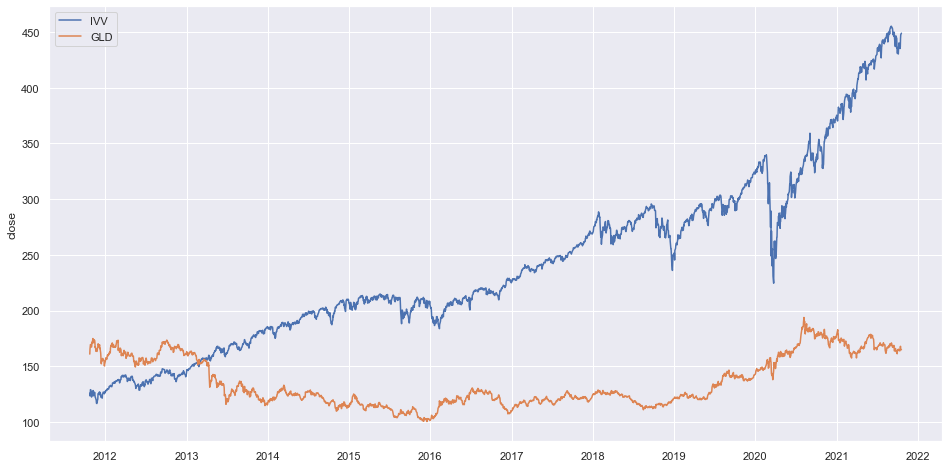

In [8]:
stock_info = {'tickers': tickers, 'starting_date': [], 'observations(days)': [], 'annual_return': [], 'variance': []}
price_hist = {}

sns.set(rc = {'figure.figsize': (16,8)})

for ticker in tickers:
    tmp = si.get_data(ticker, start_date=start.strftime("%d/%m/%Y"), end_date=end.strftime("%d/%m/%Y"))
    tmp['daily_change'] = tmp['close'].pct_change()
    stock_info['starting_date'].append(tmp.index[0])
    stock_info['annual_return'].append(tmp['daily_change'].mean() * 252)
    stock_info['variance'].append(tmp['daily_change'].var() * 252)
    stock_info['observations(days)'].append(len(tmp))
    price_hist[ticker] = tmp['daily_change']
    sns.lineplot(x=tmp.index, y='close', data=tmp, markers=True, label=ticker)
    
price_hist = pd.DataFrame.from_dict(price_hist)

df = pd.DataFrame.from_dict(stock_info)
df['std'] = df['variance'].apply(np.sqrt)
df['starting_date'] = df['starting_date'].dt.strftime('%m/%d/%Y')
df.style.format({'annual_return': '{:,.2%}'.format, 'variance': '{:,.2%}'.format, 'std': '{:,.2%}'.format})

# Correlation

Text(0.5, 1.0, 'Portfolio Pearson correlation')

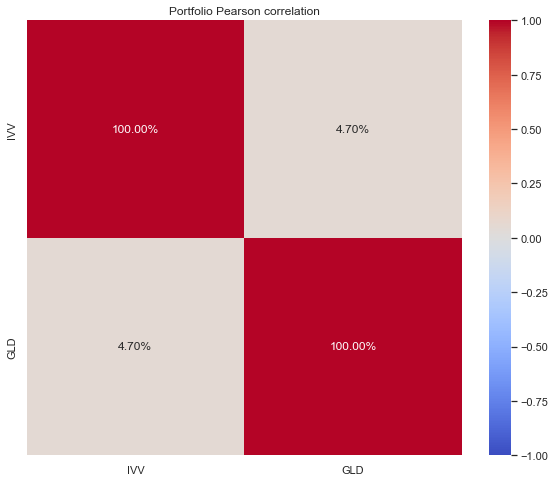

In [9]:
sns.set(rc = {'figure.figsize': (10, 8)})
sns.heatmap(
    price_hist.corr(method='pearson'), 
    annot=True, 
    square=True, 
    fmt=".2%", 
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    vmin=-1, vmax=1
).set_title('Portfolio Pearson correlation')

# Risk and Return

In [10]:
p_return = calculate_return(df['annual_return'].to_numpy(), pf['weight'].to_numpy())
p_risk = calculate_volatility((price_hist.cov() * 252).to_numpy(), pf['weight'].to_numpy())
print(
    "Portfolio_return:", "{0:.2f}%".format(p_return * 100), 
    "\nPortfolio_risk:", "{0:.2f}%".format(p_risk * 100),
    "\nSharpe ratio:", "{0:.2f}".format(calculate_sharpe_ratio(p_return, p_risk)),
)

Portfolio_return: 9.06% 
Portfolio_risk: 11.98% 
Sharpe ratio: 0.76


# PV&FV + Confidence intervals

In [11]:
ending_balances = simulate_ending_balances(
    simulations_number, 
    investment_years, 
    annual_payment, 
    initial_investment, 
    p_return, 
    p_risk,
)
get_percentile_fv_and_pv = lambda balances, rate, years, percentile: [
        np.percentile(balances, percentile), 
        npf.pv(rate, years, 0, fv=-np.percentile(balances, percentile))
]

print(
    "Your total investment over %d years is %d" % 
    (investment_years, initial_investment + annual_payment * investment_years)
)
print(
    "\nEndingBalance_Mean(FV):", "{0:.2f}".format(ending_balances.mean()), 
    "\nEndingBalance_Mean(PV):", "{0:.2f}".format(npf.pv(t_bills_30, investment_years, 0, fv=-ending_balances.mean())),
)
print("\nWith confidence of [col_name_here] you'll end up with: ")
pd.DataFrame.from_dict({
    "99%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 1),
    "95%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 5),
    "90%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 10),
    "80%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 20),
    "50%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 50),
    "20%": get_percentile_fv_and_pv(ending_balances, t_bills_30, investment_years, 80),
}).set_index([pd.Index(['FV', 'PV'])])

Your total investment over 30 years is 40000

EndingBalance_Mean(FV): 297173.25 
EndingBalance_Mean(PV): 162763.20

With confidence of [col_name_here] you'll end up with: 


,99%,95%,90%,80%,50%,20%
FV,78881.050710,110130.437031,132877.195234,166533.577095,258262.912409,402660.204083
PV,43203.524867,60318.961678,72777.468820,91211.228482,141451.819645,220538.899817


# Efficient Frontier

## Searching for best portfolio

In [12]:
rand_portfolios = generate_portfolios(
    tickers, 
    (price_hist.cov() * 252).to_numpy(), 
    df['annual_return'].to_numpy(), 
    simulations_number,
)
best_portfolio = rand_portfolios.iloc[[rand_portfolios['sharpe_ratio'].argmax()]]
print("Best portfolio:\n")
pd.DataFrame(best_portfolio).round(decimals=3)

Best portfolio:



,IVV,GLD,risk,return,sharpe_ratio
22139,0.937,0.063,0.157,0.133,0.851


## Optimize by sharpe ratio

In [13]:
cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
bounds = [(0, 1) for ticker in tickers]
init_guess = [0.25 for ticker in tickers]

print("Best portfolio optimized:\n")
best_portfolio_optimized = get_best_portfolio_optimized(
    tickers, 
    (price_hist.cov() * 252).to_numpy(), 
    df['annual_return'].to_numpy(),
    neg_sharpe,
    'SLSQP',
    cons,
    bounds
).round(decimals=3)
best_portfolio_optimized

Best portfolio optimized:



,IVV,GLD,risk,return,sharp_ratio
0,0.937,0.063,0.157,0.133,0.851


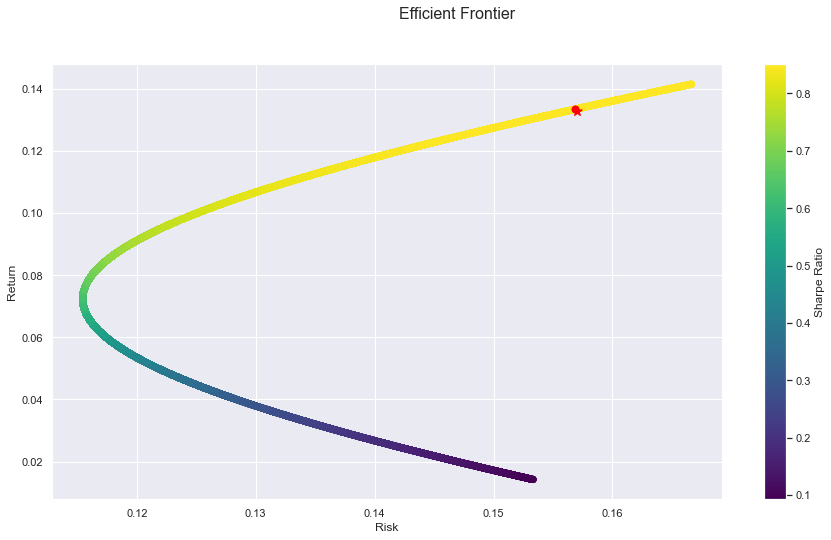

In [14]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Efficient Frontier', fontsize=16)
plt.scatter(rand_portfolios['risk'], rand_portfolios['return'], c=rand_portfolios['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.scatter(best_portfolio['risk'], best_portfolio['return'], c='red', s=50) # red dot
plt.scatter(best_portfolio_optimized['risk'], best_portfolio_optimized['return'], c='red', s=100, marker='*') # red star
plt.show()

# References
https://codingandfun.com/portfolio-risk-and-returns-python/
https://www.investopedia.com/ask/answers/041515/what-difference-between-variance-and-covariance.asp
https://www.investopedia.com/terms/c/correlationcoefficient.asp
https://www.investopedia.com/ask/answers/041315/how-covariance-used-portfolio-theory.asp
https://towardsdatascience.com/how-to-construct-an-efficient-portfolio-using-the-modern-portfolio-theory-in-python-5c5ba2b0cff4
https://medium.com/@luo9137/how-to-generate-these-popular-stock-terms-using-python-4e69c6acc6b3
https://amangupta16.medium.com/portfolio-optimization-using-python-part-1-2-9fd80097a606
https://medium.com/python-data/effient-frontier-in-python-34b0c3043314
https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5